In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

dp_mix_stan = """
data
{
    int<lower=1> I; // number of areal locations
    int<lower=1> T; // number of time steps
    int<lower=1> P; // number of covariates
    int<lower=1> H; // truncation of stick breaking construction dp
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    matrix[I,I] W_raw; # proximity matrix
      
    // hyperpar vector of regressors
    vector[P+1]     mu_0; 
    matrix[P+1,P+1] Sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
    // tau^2
    real<lower=0> a_tau2;
    real<lower=0> b_tau2;
    
    // sigma^2
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    // rho
    real<lower=0> alpha_rho;
    real<lower=0> beta_rho;
}

transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T;
    eye_T = diag_matrix(ones_T);
 
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
}

parameters
{
    real<lower=0> alpha;
    real<lower=0> sigma2;
    real<lower=0> tau2;
    real<lower=0> rho;
    
    
    // autoregressive coefficients
    vector[I]                  xis;
    
    // random effects
    matrix[T,I]                ws;
    
    // betas for the mixture of the dirichlet process
    matrix[P+1,H]              betas; 
    
    // for the construction of the dirichlet process
    vector<lower=0,upper=1>[H-1] vs;
}

transformed parameters
{   // weights stick breaking construction
    simplex[H] omegas; 
    
    // sbc stuff
    vector<lower=0, upper=1>[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];

}

model
{
    alpha  ~ gamma(a_alpha,b_alpha);
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    rho    ~ beta(alpha_rho,beta_rho);
    xis    ~ uniform(0,1); //switch between beta in (-1,1) to uniform(0,1)
    vs     ~ beta(1,alpha);

    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    ws[1,1:I] ~ multi_normal(mu_w_1, tau2*inv_Q);
    
    for (t in 2:T)
        ws[t,1:I] ~ multi_normal(ws[t-1,1:I]*diag_matrix(xis), tau2*inv_Q);
    
    for (h in 1:H)
        betas[1:P+1,h] ~ multi_normal(mu_0, Sigma_0);
        
    for (i in 1:I) 
    {
        vector[H] log_probs;
        
        for (h in 1:H) 
            log_probs[h] = log(omegas[h] + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h] + ws[1:T,i], sigma2*eye_T));
        
        target += log_sum_exp(log_probs);
    }
}

generated quantities 
{   
    // vector of cluster allocations
    vector[I] s;
    
    for (i in 1:I) 
    {
        vector[H] log_probs;
        
        for (h in 1:H) 
            log_probs[h] = log(omegas[h] + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  + ws[1:T,i]  , sigma2*eye_T));
        
        s[i] = categorical_rng(softmax(log_probs));
    }
}
"""

stan_file = "bayesian.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)

10:14:02 - cmdstanpy - INFO - compiling stan file /home/riccardo/bayesian-project/bayesian.stan to exe file /home/riccardo/bayesian-project/bayesian
10:14:40 - cmdstanpy - INFO - compiled model executable: /home/riccardo/bayesian-project/bayesian


[[1. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0. 1. 1. 0. 0. 1.]
 [0. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 0. 1. 0. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 0. 1. 1.]]


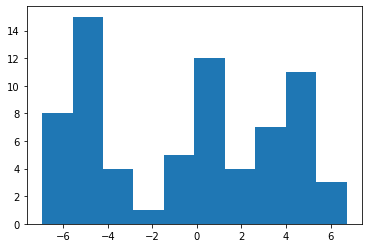

In [21]:
I = 10
T = 7
P = 3
means = np.array([-5, 0, 5]) #vector of possible mean 
y = np.zeros(I*T)
true_clus_allocs = np.zeros(I) #cluster of each areal allocation 
for i in range(1,I+1): #for each areal location 
    true_clus = np.random.choice(np.arange(3), size=1) #choose a cluster randomly between (1,2,3)
    true_clus_allocs[i-1] = true_clus #save the cluster choosen
    y[T*(i-1):T*i] = np.random.normal(loc=means[true_clus],size= T) #sample for all the time from the cluster choosen
    # this are the data related to areal i for all time until T
plt.hist(y)

X = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
   X[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly


mu_0 = np.zeros(P+1) #as in the paper
mu_w_1 = np.zeros(I) #as in the paper

W_raw = np.eye(I) #proximity matrix, ones in the diagonal, symm, just made by 1 or 0
for i in range(I):
    for j in range(i):
        W_raw[i,j] = np.random.binomial(size=1, n=1, p= 0.5) #choosen rand from a bernoulli
        W_raw[j,i] = W_raw[i,j] #it has to be symm
print(W_raw)

Sigma_0 = np.eye(P+1) #covariance matrix


data = {
    "I": I,
    "T": T,
    "P": P,
    "H": 10,
    "y": y,
    "X": X,
    "W_raw": W_raw,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "alpha_rho": 5,
    "beta_rho": 1
}


In [22]:
true_clus_allocs

array([2., 0., 1., 0., 0., 2., 2., 1., 0., 1.])

In [23]:
fit = dp_mix.sample(data, show_console = True)

10:41:38 - cmdstanpy - INFO - Chain [1] start processing
10:41:38 - cmdstanpy - INFO - Chain [2] start processing
10:41:38 - cmdstanpy - INFO - Chain [3] start processing
10:41:38 - cmdstanpy - INFO - Chain [4] start processing
10:41:38 - cmdstanpy - INFO - Chain [1] done processing
10:41:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
10:41:38 - cmdstanpy - INFO - Chain [3] done processing
10:41:38 - cmdstanpy - INFO - Chain [2] done processing
10:41:38 - cmdstanpy - ERROR - Chain [3] error: error during processing Operation not permitted
10:41:38 - cmdstanpy - ERROR - Chain [2] error: error during processing Operation not permitted
10:41:38 - cmdstanpy - INFO - Chain [4] done processing
10:41:38 - cmdstanpy - ERROR - Chain [4] error: error during processing Operation not permitted


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1000 (Default)
Chain [1] num_warmup = 1000 (Default)
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /tmp/tmp997xn3yu/k529egsa.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 19373
Chain [1] output
Chai

RuntimeError: Error during sampling:
Exception: beta_lpdf: Random variable is 1.47547, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.85688, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.91686, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.87385, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.01657, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.86357, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.45453, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.43503, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.72302, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.2563, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.3679, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.18185, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.56807, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.46875, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.97296, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.4063, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.56262, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.52911, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.2336, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.91546, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.47671, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.62967, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.21572, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.06856, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.98422, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.40887, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.69628, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.52048, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.51872, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.11095, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.35251, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.85568, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.58235, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.10815, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.84374, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.95942, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.75047, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.43053, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.37091, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.47645, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.74783, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.06836, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.98907, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.57949, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.29059, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.51361, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.54726, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.66341, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.6104, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.4749, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.94664, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.8818, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.5787, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.89365, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.93955, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
Exception: beta_lpdf: Random variable is 1.09195, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.00902, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.99305, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.91208, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.46023, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.02376, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.21271, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.31673, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.84887, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.30876, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.99558, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.58498, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.72527, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.17038, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.03296, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.18056, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.09599, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.90398, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.88615, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.8316, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.44024, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.51555, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.22615, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.76206, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.51234, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.74457, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.59746, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.25166, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.72135, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.70329, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.71514, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.38969, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.66914, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.1392, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.4926, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.58356, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.26446, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.32483, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.4098, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.13614, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.34073, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
Exception: beta_lpdf: Random variable is 2.57528, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.13719, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.38622, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.86918, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.38308, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.15412, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.57458, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.20705, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.98181, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.31037, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.02912, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.91969, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 7.24209, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.66142, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.66307, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.32748, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.91446, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.95165, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.98971, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.40339, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.68909, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.38123, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.77207, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.96411, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.14009, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.4695, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.50932, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.38102, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.03879, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.01206, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.76675, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.49846, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.24511, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.85245, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.16101, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.46383, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.95683, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.88732, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.18115, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.3056, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.54773, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.16733, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.26711, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.59851, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.66674, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
Exception: beta_lpdf: Random variable is 1.52194, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.52302, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.66909, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.7671, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.58752, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.81669, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.8774, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.56589, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.35911, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.09724, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.08125, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.8692, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.05727, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.05296, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.29964, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.2249, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.94228, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.01929, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.96847, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 7.16786, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.99341, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.84587, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.65712, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.75714, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.50654, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.60083, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.62531, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 6.08581, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.75735, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.3463, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.78007, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.78225, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.59687, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.15691, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.35277, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.70636, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 3.01404, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.3849, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 5.54798, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.12059, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.25578, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.46002, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 2.285, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 1.67288, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.84905, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
	Exception: beta_lpdf: Random variable is 4.45285, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/bayesian.stan', line 92, column 4 to column 38)
Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/home/riccardo/bayesian-project/bayesian', 'id=1', 'random', 'seed=19373', 'data', 'file=/tmp/tmp997xn3yu/k529egsa.json', 'output', 'file=/tmp/tmp997xn3yu/bayesianm_lhpge8/bayesian-20221216104138_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[1, 1, 1, 1]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp997xn3yu/bayesianm_lhpge8/bayesian-20221216104138_1.csv
 console_msgs (if any):
	/tmp/tmp997xn3yu/bayesianm_lhpge8/bayesian-20221216104138_0-stdout.txt
Consider re-running with show_console=True if the above output is unclear!